## Notebook for training Chemprop models (including hyperparameter optimization) & predicting on train, validation, test sets

### Target property: Oxidative stability

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
import matplotlib
plt.rcParams['font.family'] = 'Arial'
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools

In [ ]:
## steps to install Chemprop (recommended to create a new environment)
## original documentation recommends python 3.8
# !conda install -c conda-forge rdkit
# !pip install git+https://github.com/bp-kelley/descriptastorus
# !pip install chemprop

### Split: Random

#### Step 1: Finding best activation function for oxidative stability prediction

In [ ]:
%%bash
train_rand="../../datasets/raw/oxstab_train_random.csv"
val_rand="../../datasets/raw/oxstab_val_random.csv"
test_rand="../../datasets/raw/oxstab_test_random.csv"

for i in ReLU LeakyReLU PReLU tanh SELU ELU
do
dir="test_act_oxstab_${i}"
echo $i
chemprop_train --data_path ${train_rand} --dataset_type 'regression' --save_dir ${dir} --separate_val_path ${val_rand} --separate_test_path ${test_rand} --activation $i --extra_metrics 'r2'
done

**Note:** Different folders will be created for each activation function (test_act_oxstab_ReLU, test_act_oxstab_SELU, etc.). Inside each folder look at the metrics in file named 'quite.log' and select the activation function that gives highest R2. The best activation was found to be 'SELU' for oxidative stability prediction, which will be used in the rest of the notebook

#### Step 2: Bayesian hyperparameter optimization

In [ ]:
%%bash
train_rand="../../datasets/raw/oxstab_train_random.csv"
val_rand="../../datasets/raw/oxstab_val_random.csv"
test_rand="../../datasets/raw/oxstab_test_random.csv"

chemprop_hyperopt --data_path ${train_rand} --separate_val_path ${val_rand} --separate_test_path ${test_rand} --config_save_path 'hyp_opt_oxstab.conf' --num_iters 20 --save_dir 'hyp_selu_oxstab' --dataset_type 'regression' --activation 'SELU' --epochs 30 --resume_experiment

**Note:** Best hyperparameters that result in lowest error on test set will be saved in the file 'hyp_opt_oxstab.conf'

#### Step 3: Training Chemprop model using activation function obtained from Step 1 & hyperparameters from Step 2

In [ ]:
%%bash
train_rand="../../datasets/raw/oxstab_train_random.csv"
val_rand="../../datasets/raw/oxstab_val_random.csv"
test_rand="../../datasets/raw/oxstab_test_random.csv"
save_dir="oxstab_selu_epoch100f5e3_rand_s700"

## 5-fold CV (num_folds) | 3 models with different randomly initialized weights for each fold (ensemble_size) | epochs = 100
chemprop_train --data_path ${train_rand} --extra_metrics 'r2' --save_dir ${save_dir} --separate_val_path ${val_rand} --separate_test_path ${test_rand} --activation 'SELU' --epochs 100 --dataset_type 'regression' --save_smiles_splits --show_individual_scores --save_preds --num_folds 5 --config_path './hyp_opt_oxstab.conf' --ensemble_size 3

**Note:** The model checkpoints are provided in the directory '../../models/Chemprop/oxstab_selu_epoch100f5e3_rand_s700' as it takes quite a long time to train Chemprop models

#### Step 4: Predict on train, validation, and test sets (For Figure 2(b))

In [ ]:
%%bash
train_rand="../../datasets/raw/oxstab_train_random.csv"
pred_train_rand="../../datasets/predicted/preds_train_oxstab_chemprop_epoch100f5e3_rand_s700.csv"
val_rand="../../datasets/raw/oxstab_val_random.csv"
pred_val_rand="../../datasets/predicted/preds_val_oxstab_chemprop_epoch100f5e3_rand_s700.csv"
test_rand="../../datasets/raw/oxstab_test_random.csv"
pred_test_rand="../../datasets/predicted/preds_test_oxstab_chemprop_epoch100f5e3_rand_s700.csv"
model_checkpoint="../../models/Chemprop/oxstab_selu_epoch100f5e3_rand_s700" ## change accordingly

## predict using ensemble of 15 models on train set
chemprop_predict --test_path ${train_rand} --preds_path ${pred_train_rand} --checkpoint_dir ${model_checkpoint} --ensemble_variance
## predict using ensemble of 15 models on val set
chemprop_predict --test_path ${val_rand} --preds_path ${pred_val_rand} --checkpoint_dir ${model_checkpoint} --ensemble_variance
## predict using ensemble of 15 models on test set
chemprop_predict --test_path ${test_rand} --preds_path ${pred_test_rand} --checkpoint_dir ${model_checkpoint} --ensemble_variance

**Plot hexabin parity plot for Chemprop model trained on random split (Figure 2(e))**

In [ ]:
fig, ax = plt.subplots()
extent = [min(y_train_true), max(y_train_true), min(y_train_pred), max(y_train_pred)]
# norm = plt.Normalize(axmin, axmax)
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.298, 0.78, 0.77),(0, 0.576, 0.902)]) ## anvil, blue
# cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.298, 0.78, 0.77),'blue'])
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.95, 0.78, 0.996),(0.557, 0, 0.998)]) ## pink, dark purple
cmap3 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.984, 0.713, 0.305),(0.984, 0.262, 0.219)]) ## orange, red
# cmap3 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.984, 0.713, 0.305),(0.349,0.745,0.306)]) ## orange, green
hb = ax.hexbin(y_train_true, y_train_pred, gridsize=40, cmap=cmap3, bins='log', edgecolors=None)
hb1 = ax.hexbin(y_val_true, y_val_pred, gridsize=30, cmap=cmap2, bins='log', edgecolors=None)
hb2 = ax.hexbin(y_test_true, y_test_pred, gridsize=30, cmap=cmap1, bins='log', edgecolors=None)
# hb = ax.hexbin(y_train_true, y_train_pred, gridsize=50, cmap='Blues', bins='log', edgecolors='white') ## original snippet
# ax0.set(xlim=xlim, ylim=ylim)
# ax0.set_title("Hexagon binning")
cb = fig.colorbar(hb)
cb1 = fig.colorbar(hb1)
cb2 = fig.colorbar(hb2)
# cb2 = fig.colorbar(hb2, ax=ax, label='counts')
# plt.show()
plt.savefig('legend_hexbin_performance_ie_chemprop_new.eps', dpi=300)

In [ ]:
y_train_true = pd.read_csv('../../datasets/raw/oxstab_train_random.csv')['IE']
y_train_pred = pd.read_csv('../../datasets/predicted/preds_train_oxstab_chemprop_epoch100f5e3_rand_s700.csv')['IE']
y_val_true = pd.read_csv('../../datasets/raw/oxstab_val_random.csv')['IE']
y_val_pred = pd.read_csv('../../datasets/predicted/preds_val_oxstab_chemprop_epoch100f5e3_rand_s700.csv')['IE']
y_test_true = pd.read_csv('../../datasets/raw/oxstab_test_random.csv')['IE']
y_test_pred = pd.read_csv('../../datasets/predicted/preds_test_oxstab_chemprop_epoch100f5e3_rand_s700.csv')['IE']

r2_train = r2_score(y_train_true, y_train_pred)
r2_val = r2_score(y_val_true, y_val_pred)
r2_test = r2_score(y_test_true, y_test_pred)

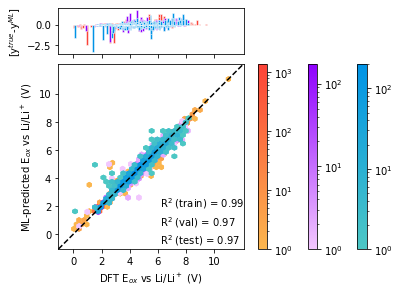

In [ ]:
def scatter_hist(x, y, ax, ax_histx, size, color_map, color):
    ax_histx.tick_params(axis="x", labelbottom=False)
    # ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.hexbin(x, y, gridsize=size, bins='log', cmap=color_map, edgecolors=None)

    # now determine nice limits by hand:
    binwidth = 0.15
    binwidth = (axmax - axmin) / 100

    bins = np.arange(axmin, axmax + binwidth, binwidth)
    residual = x-y
    ax_histx.bar(x, residual, width=binwidth, color=color, edgecolor='white', linewidth=0.5)

    hb = ax.hexbin(x, y, gridsize=size, bins='log', cmap=color_map, edgecolors=None)
    return hb

fig = plt.figure(constrained_layout=True)
ax = fig.add_gridspec(top=0.5, right=0.75).subplots()

cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.298, 0.78, 0.77),(0, 0.576, 0.902)]) ## anvil, blue
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.95, 0.78, 0.996),(0.557, 0, 0.998)]) ## pink, dark purple
cmap3 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.984, 0.713, 0.305),(0.984, 0.262, 0.219)]) ## orange, red

axmin = min(min(y_train_true), min(y_train_pred)) - 0.1*(max(y_train_true)-min(y_train_true))
axmax = max(max(y_train_true), max(y_train_pred)) + 0.1*(max(y_train_true)-min(y_train_true))

x_ = np.arange(axmin, axmax, 0.1)
y_ = np.arange(axmin, axmax, 0.1)

ax.set(aspect=1)
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)

x1 = y_train_true; y1 = y_train_pred
x2 = y_val_true; y2 = y_val_pred
x3 = y_test_true; y3 = y_test_pred
hb1 = scatter_hist(x1, y1, ax, ax_histx, 30, cmap3, (0.984, 0.262, 0.219))
hb2 = scatter_hist(x2, y2, ax, ax_histx, 20, cmap2, (0.557, 0, 0.998))
hb3 = scatter_hist(x3, y3, ax, ax_histx, 20, cmap1, (0, 0.576, 0.902))
ax.plot(x_, y_, color='black', linestyle='--')
ax.set_xlabel('DFT E$_{ox}$ vs Li/Li$^+$ (V)')
ax.set_ylabel('ML-predicted E$_{ox}$ vs Li/Li$^+$ (V)')
ax.text(0.55, 0.25, f'R$^2$ (train) = {r2_train:.2f}', ha='left', va='center', transform=ax.transAxes)
ax.text(0.55, 0.15, f'R$^2$ (val) = {r2_val:.2f}', ha='left', va='center', transform=ax.transAxes)
ax.text(0.55, 0.05, f'R$^2$ (test) = {r2_test:.2f}', ha='left', va='center', transform=ax.transAxes)
ax.set_xlim(axmin, axmax)
ax.set_ylim(axmin, axmax)
ax.set_xticks([0, 2, 4, 6, 8, 10])
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax_histx.set_ylabel('[y$^{true}$-y$^{ML}$]')

fig.colorbar(hb3)
fig.colorbar(hb2)
fig.colorbar(hb1)

### Split: Scaffold

#### Step 3: Training Chemprop model

$-$ Using the activation function and hyperparameters obtained from random split

In [ ]:
%%bash
train_scaff="../../datasets/raw/oxstab_train_scaffold.csv"
val_scaff="../../datasets/raw/oxstab_val_scaffold.csv"
test_scaff="../../datasets/raw/oxstab_test_scaffold.csv"
save_dir="oxstab_selu_epoch100f5e3_scaff_s700"

## 5-fold CV (num_folds) | 3 models with different randomly initialized weights for each fold (ensemble_size) | epochs = 100
chemprop_train --data_path ${train_scaff} --extra_metrics 'r2' --save_dir ${save_dir} --separate_val_path ${val_scaff} --separate_test_path ${test_scaff} --activation 'SELU' --epochs 100 --dataset_type 'regression' --save_smiles_splits --show_individual_scores --save_preds --num_folds 5 --config_path './hyp_opt_oxstab.conf' --ensemble_size 3

#### Step 4: Predict on train, validation, and test sets (For Figure 2(b))

In [ ]:
%%bash
train_scaff="../../datasets/raw/oxstab_train_scaffold.csv"
pred_train_scaff="../../datasets/predicted/preds_train_oxstab_chemprop_epoch100f5e3_scaff_s700.csv"
val_scaff="../../datasets/raw/oxstab_val_scaffold.csv"
pred_val_scaff="../../datasets/predicted/preds_val_oxstab_chemprop_epoch100f5e3_scaff_s700.csv"
test_scaff="../../datasets/raw/oxstab_test_scaffold.csv"
pred_test_scaff="../../datasets/predicted/preds_test_oxstab_chemprop_epoch100f5e3_scaff_s700.csv"
model_checkpoint="../../models/Chemprop/oxstab_selu_epoch100f5e3_scaff_s700" ## change accordingly

## predict using ensemble of 15 models on train set
chemprop_predict --test_path ${train_scaff} --preds_path ${pred_train_scaff} --checkpoint_dir ${model_checkpoint} --ensemble_variance
## predict using ensemble of 15 models on val set
chemprop_predict --test_path ${val_scaff} --preds_path ${pred_val_scaff} --checkpoint_dir ${model_checkpoint} --ensemble_variance
## predict using ensemble of 15 models on test set
chemprop_predict --test_path ${test_scaff} --preds_path ${pred_test_scaff} --checkpoint_dir ${model_checkpoint} --ensemble_variance

#### Split: Stratified-I

#### Step 3: Training Chemprop model

$-$ Using the activation function and hyperparameters obtained from random split

In [ ]:
%%bash
train_strat1="../../datasets/raw/oxstab_train_strat1.csv"
val_strat1="../../datasets/raw/oxstab_val_strat1.csv"
test_strat1="../../datasets/raw/oxstab_test_strat1.csv"
save_dir="oxstab_selu_epoch100f5e3_strat1_s700"

## 5-fold CV (num_folds) | 3 models with different randomly initialized weights for each fold (ensemble_size) | epochs = 100
chemprop_train --data_path ${train_strat1} --extra_metrics 'r2' --save_dir ${save_dir} --separate_val_path ${val_strat1} --separate_test_path ${test_strat1} --activation 'SELU' --epochs 100 --dataset_type 'regression' --save_smiles_splits --show_individual_scores --save_preds --num_folds 5 --config_path './hyp_opt_oxstab.conf' --ensemble_size 3

#### Step 4: Predict on train, validation, and test sets (For Figure 2(b))

In [ ]:
%%bash
train_strat1="../../datasets/raw/oxstab_train_strat1.csv"
pred_train_strat1="../../datasets/predicted/preds_train_oxstab_chemprop_epoch100f5e3_strat1_s700.csv"
val_strat1="../../datasets/raw/oxstab_val_strat1.csv"
pred_val_strat1="../../datasets/predicted/preds_val_oxstab_chemprop_epoch100f5e3_strat1_s700.csv"
test_strat1="../../datasets/raw/oxstab_test_strat1.csv"
pred_test_strat1="../../datasets/predicted/preds_test_oxstab_chemprop_epoch100f5e3_strat1_s700.csv"
model_checkpoint="../../models/Chemprop/oxstab_selu_epoch100f5e3_strat1_s700" ## change accordingly

## predict using ensemble of 15 models on train set
chemprop_predict --test_path ${train_strat1} --preds_path ${pred_train_strat1} --checkpoint_dir ${model_checkpoint} --ensemble_variance
## predict using ensemble of 15 models on val set
chemprop_predict --test_path ${val_strat1} --preds_path ${pred_val_strat1} --checkpoint_dir ${model_checkpoint} --ensemble_variance
## predict using ensemble of 15 models on test set
chemprop_predict --test_path ${test_strat1} --preds_path ${pred_test_strat1} --checkpoint_dir ${model_checkpoint} --ensemble_variance

#### Split: Stratified-II

#### Step 3: Training Chemprop model

$-$ Using the activation function and hyperparameters obtained from random split

**Important note to consider:** The purpose of creating this split is to enable the models to only see the same range of values in train, validation, and test sets, but also to see same range of values during (5-fold stratified) cross-validation. However, Chemprop creates its own 5-fold cross-validation random splits, to bypass this behavior we created our own 5-fold stratified cross-validation splits & trained Chemprop models individually (refer to [this notebook](../creating-data-splits/split_dataset_strat2_oxstab.ipynb#section_id1) for creating the stratified sets & stratified cross-validation splits)

In [ ]:
%%bash
save_dir="oxstab_selu_epoch100f5e3_strat2_s700"
for value in {0..4}
do
    ## performing Chemprop training for each stratified fold manually by going into each folder
    chemprop_train --data_path ${save_dir}/fold_${value}/train_full.csv --separate_val_path ${save_dir}/fold_${value}/val_full.csv --separate_test_path ${save_dir}/fold_${value}/test_full.csv --save_dir ${save_dir}/fold_${value} --epochs 100 --ensemble_size 3 --dataset_type 'regression' --activation 'SELU' --config_path './hyp_opt_oxstab.conf' --extra_metrics 'r2' --save_preds --num_folds 1 --target_columns 'IE'
done

**Note:** The model checkpoints as well as the required train-validation-test set files for each stratified fold are provided in the directory '../../models/Chemprop/oxstab_selu_epoch100f5e3_strat2_s700'

#### Step 4: Predict on train, validation, and test sets (For Figure 2(b))

In [ ]:
%%bash
train_strat2="../../datasets/raw/oxstab_train_strat2.csv"
pred_train_strat2="../../datasets/predicted/preds_train_oxstab_chemprop_epoch100f5e3_strat2_s700.csv"
val_strat2="../../datasets/raw/oxstab_val_strat2.csv"
pred_val_strat2="../../datasets/predicted/preds_val_oxstab_chemprop_epoch100f5e3_strat2_s700.csv"
test_strat2="../../datasets/raw/oxstab_test_strat2.csv"
pred_test_strat2="../../datasets/predicted/preds_test_oxstab_chemprop_epoch100f5e3_strat2_s700.csv"
model_checkpoint="../../models/Chemprop/oxstab_selu_epoch100f5e3_strat2_s700" ## change accordingly

## predict using ensemble of 15 models on train set
chemprop_predict --test_path ${train_strat2} --preds_path ${pred_train_strat2} --checkpoint_dir ${model_checkpoint} --ensemble_variance
## predict using ensemble of 15 models on val set
chemprop_predict --test_path ${val_strat2} --preds_path ${pred_val_strat2} --checkpoint_dir ${model_checkpoint} --ensemble_variance
## predict using ensemble of 15 models on test set
chemprop_predict --test_path ${test_strat2} --preds_path ${pred_test_strat2} --checkpoint_dir ${model_checkpoint} --ensemble_variance